In [ ]:
# ==========================================
# CELL 1: CÀI ĐẶT THƯ VIỆN
# ==========================================
!pip install transformers datasets pyvi accelerate scikit-learn -q
print("Đã cài đặt xong thư viện!")

In [ ]:
# ==========================================
# CELL 2: MOUNT DRIVE & CẤU HÌNH PATH
# ==========================================
import os


# Đường dẫn github
TRAIN_PATH = 'https://raw.githubusercontent.com/Vietnam-NLI-Project/vietnam-nli-project/refs/heads/main/data/train.csv'
DEV_PATH   = 'https://raw.githubusercontent.com/Vietnam-NLI-Project/vietnam-nli-project/refs/heads/main/data/dev.csv'
TEST_PATH  = 'https://raw.githubusercontent.com/Vietnam-NLI-Project/vietnam-nli-project/refs/heads/main/data/test.csv'
AUG_PATH   = 'https://raw.githubusercontent.com/Vietnam-NLI-Project/vietnam-nli-project/refs/heads/main/data/train_augmented.csv'

print(f"Đã cấu hình đường dẫn dữ liệu từ GitHub")

In [ ]:
# ==========================================
# CELL 3: ĐỌC DỮ LIỆU & XỬ LÝ
# ==========================================
import pandas as pd
from pyvi import ViTokenizer
from datasets import Dataset

# 1. Đọc dữ liệu
print("Đang đọc dữ liệu...")
train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(DEV_PATH)
test_df  = pd.read_csv(TEST_PATH)

# 2. Chuẩn hóa tên cột (Label -> label)
print("Đang chuẩn hóa tên cột...")
for df in [train_df, val_df, test_df]:
    if 'Label' in df.columns:
        df.rename(columns={'Label': 'label'}, inplace=True)

# Kiểm tra an toàn
if 'label' not in train_df.columns:
    raise ValueError(f"Lỗi: Không tìm thấy cột 'label'. Các cột hiện có: {train_df.columns.tolist()}")

# 3. Tách từ tiếng Việt (Tokenizing)
print("Đang tách từ (ViTokenizer)...")
def preprocess_text(text):
    text = str(text) if pd.notna(text) else ""
    return ViTokenizer.tokenize(text)

for df in [train_df, val_df, test_df]:
    df['Premise'] = df['Premise'].apply(preprocess_text)
    df['Hypothesis'] = df['Hypothesis'].apply(preprocess_text)

# 4. Chuyển sang định dạng Dataset của HuggingFace
train_dataset = Dataset.from_pandas(train_df[['Premise', 'Hypothesis', 'label']])
eval_dataset  = Dataset.from_pandas(val_df[['Premise', 'Hypothesis', 'label']])
test_dataset  = Dataset.from_pandas(test_df[['Premise', 'Hypothesis', 'label']])

print("Xử lý dữ liệu hoàn tất!")

In [ ]:
# ==========================================
# CELL 3: ĐỌC DỮ LIỆU & XỬ LÝ (Thêm data)
# ==========================================
import pandas as pd
from pyvi import ViTokenizer
from datasets import Dataset

# 1. Đọc dữ liệu
print("Đang đọc dữ liệu...")
train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(DEV_PATH)
test_df  = pd.read_csv(TEST_PATH)
aug_df = pd.read_csv(AUG_PATH)

# 2. Chuẩn hóa tên cột (Label -> label)
print("Đang chuẩn hóa tên cột...")
for df in [train_df, val_df, test_df, aug_df]:
    if 'Label' in df.columns:
        df.rename(columns={'Label': 'label'}, inplace=True)

# Kiểm tra an toàn
if 'label' not in train_df.columns:
    raise ValueError(f"Lỗi: Không tìm thấy cột 'label'. Các cột hiện có: {train_df.columns.tolist()}")

# Gộp data mới và train
print(f"Trước khi gộp: Train cũ = {len(train_df)}, Data mới = {len(aug_df)}")
train_df = pd.concat([train_df, aug_df], ignore_index=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"-> Sau khi gộp và shuffle: Tổng Train = {len(train_df)}")

# Kiểm tra phân bố nhãn mới
print("Phân bố nhãn sau khi thêm data:")
print(train_df['label'].value_counts())

# 3. Tách từ tiếng Việt (Tokenizing)
print("Đang tách từ (ViTokenizer)...")
def preprocess_text(text):
    text = str(text) if pd.notna(text) else ""
    return ViTokenizer.tokenize(text)

for df in [train_df, val_df, test_df]:
    df['Premise'] = df['Premise'].apply(preprocess_text)
    df['Hypothesis'] = df['Hypothesis'].apply(preprocess_text)

# 4. Chuyển sang định dạng Dataset của HuggingFace
train_dataset = Dataset.from_pandas(train_df[['Premise', 'Hypothesis', 'label']])
eval_dataset  = Dataset.from_pandas(val_df[['Premise', 'Hypothesis', 'label']])
test_dataset  = Dataset.from_pandas(test_df[['Premise', 'Hypothesis', 'label']])

print("Xử lý dữ liệu hoàn tất!")

In [ ]:
# ==========================================
# CELL 4: MÃ HÓA (TOKENIZATION)
# ==========================================
from transformers import AutoTokenizer

MODEL_NAME = "vinai/phobert-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples["Premise"],
        examples["Hypothesis"],
        truncation=True,
        max_length=256,
        padding=False
    )

print("Đang mã hóa dữ liệu cho PhoBERT...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset  = eval_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

# Xóa cột text gốc để nhẹ bộ nhớ
for ds in [train_dataset, eval_dataset, test_dataset]:
    ds = ds.remove_columns(['Premise', 'Hypothesis'])

print("Mã hóa hoàn tất!")

In [ ]:
# ==========================================
# CELL 5: HUẤN LUYỆN (TRAINING)
# ==========================================
import torch
import numpy as np
from torch import nn
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

# Đặt trọng số cao cho nhãn contradiction
class_weights = torch.tensor([1.2, 1.5, 1.0]).to(device)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Tính toán loss với trọng số đã định nghĩa
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

        return (loss, outputs) if return_outputs else loss

# Load Model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to(device)

# Hàm tính độ chính xác
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Cấu hình Train
training_args = TrainingArguments(
    output_dir="./phobert_nli_results",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs',
    logging_steps=50,
    report_to="none"
)

# Khởi tạo Trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

print("--- BẮT ĐẦU FINE-TUNING ---")
trainer.train()
print("--- HUẤN LUYỆN KẾT THÚC ---")

Đang sử dụng thiết bị: cuda


pytorch_model.bin:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

/tmp/ipython-input-2679774059.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


--- BẮT ĐẦU FINE-TUNING ---


Epoch,Training Loss,Validation Loss,Accuracy
1,1.019900,1.003487,0.328638
2,0.780500,0.775688,0.558685
3,0.454600,0.542208,0.816901
4,0.245200,0.524728,0.835681
5,0.196700,0.579753,0.821596
6,0.127100,0.571077,0.845070


--- HUẤN LUYỆN KẾT THÚC ---


In [ ]:
# ==========================================
# CELL 6: LƯU MODEL
# ==========================================
import os

# --- LƯU MODEL & TOKENIZER ---
save_path = "./Best_PhoBERT_Model"

# 1. Lưu Model
trainer.save_model(save_path)
# 2. Lưu Tokenizer
tokenizer.save_pretrained(save_path)

print(f"Đã lưu thành công Model và Tokenizer tại: {save_path}")

In [ ]:
# ==========================================
# CELL 7: PHÂN TÍCH THEO GENRE
# ==========================================
print("\n--- ĐỘ CHÍNH XÁC THEO TỪNG LĨNH VỰC (GENRE) ---")

# Lấy dự đoán
# analysis_df lấy từ test_df gốc
analysis_df = test_df.copy()
analysis_df['Predicted'] = y_pred

genres = analysis_df['Genre'].unique()

print(f"{'GENRE':<15} | {'SỐ LƯỢNG':<10} | {'ĐỘ CHÍNH XÁC':<20}")
print("-" * 55)

for g in genres:
    subset = analysis_df[analysis_df['Genre'] == g]
    acc = accuracy_score(subset['label'], subset['Predicted'])
    print(f"{g:<15} | {len(subset):<10} | {acc:.2%}")

print("-" * 55)


--- ĐỘ CHÍNH XÁC THEO TỪNG LĨNH VỰC (GENRE) ---
GENRE           | SỐ LƯỢNG   | ĐỘ CHÍNH XÁC        
-------------------------------------------------------
Social          | 54         | 90.74%
News            | 54         | 88.89%
Knowledge       | 54         | 70.37%
Fiction         | 51         | 88.24%
-------------------------------------------------------


Đang dự đoán...


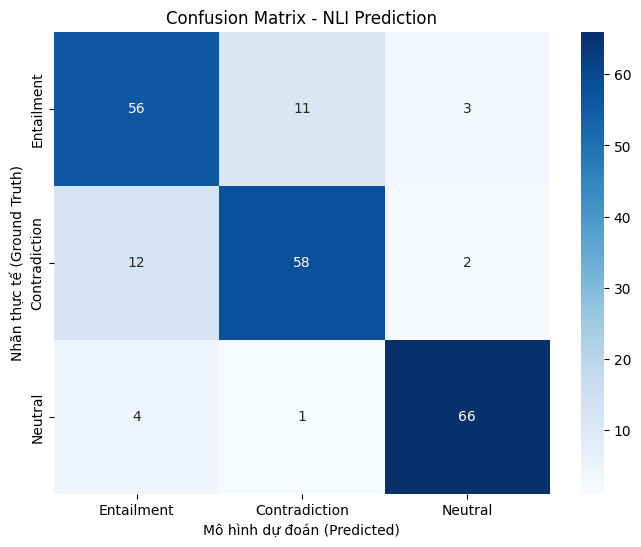


--- BÁO CÁO CHI TIẾT ---
               precision    recall  f1-score   support

   Entailment     0.7778    0.8000    0.7887        70
Contradiction     0.8286    0.8056    0.8169        72
      Neutral     0.9296    0.9296    0.9296        71

     accuracy                         0.8451       213
    macro avg     0.8453    0.8450    0.8451       213
 weighted avg     0.8455    0.8451    0.8452       213



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. Dự đoán trên tập Test
print("Đang dự đoán...")
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# 2. Tính Confusion Matrix
cm = confusion_matrix(labels, preds)

# 3. Vẽ biểu đồ
target_names = ['Entailment', 'Contradiction', 'Neutral']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Nhãn thực tế (Ground Truth)')
plt.xlabel('Mô hình dự đoán (Predicted)')
plt.title('Confusion Matrix - NLI Prediction')
plt.show()

# 4. In báo cáo chi tiết
print("\n--- BÁO CÁO CHI TIẾT ---")
print(classification_report(labels, preds, target_names=target_names, digits=4))